In [13]:
import os
os.environ["CC"] = "gcc"
os.environ["CXX"] = "gcc"
import sys
sys.path.append('/usr/lib/python3/dist-packages')
import imageio
import torch

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
%matplotlib inline

from pix_transform.pix_transform import PixTransform
from baselines.baselines import bicubic
from utils.utils import downsample,align_images
from prox_tv import tvgen
from utils.plots import plot_result
from pix_transform.pix_transform_net import PixTransformNet

In [14]:
directory = os.path.dirname(os.getcwd())
directory

'/home/beast2020/Desktop/mingchi'

In [15]:
####  define parameters  ########################################################
params = {'img_idxs' : [], # idx images to process, if empty then all of them
            
          'scaling': 8,
          'greyscale': False, # Turn image into grey-scale
          'channels': -1,
          
          'spatial_features_input': True,
          'weights_regularizer': [0.0001, 0.001, 0.0001], # spatial color head
          'loss': 'l1',
 
          'optim': 'adam',
          'lr': 0.001,
                  
          'batch_size': 32,
          'iteration': 1024*60*90//32, # could //4 or //16 for debugging, so to save time
                  
          'logstep': 16,
          
          'final_TGV' : False, # Total Generalized Variation in post-processing
          'align': False, # Move image around for evaluation in case guide image and target image are not perfectly aligned
          'delta_PBP': 1, # Delta for percentage of bad pixels 
         }



## get all images, nadir + oblique

In [16]:
rgb_dir = directory+'/EPFL_10_newsample_nadir/rgb/'
_files = os.listdir(rgb_dir)
_files.sort()
_rgb_files = [rgb_dir + f for f in _files]
_rgb_files.sort()
# print(_rgb_files)

dist_dir = directory+'/EPFL_10_newsample_nadir/dist/'
_files = os.listdir(dist_dir)
_files.sort()
_dist_files = [dist_dir + f for f in _files]
_dist_files.sort()
# print(_dist_files)

rgb_dir_ob = directory+'/EPFL_10_newsample_ob/rgb/'
_files_ob = os.listdir(rgb_dir_ob)
_files_ob.sort()
_rgb_files_ob = [rgb_dir_ob + f for f in _files_ob]
_rgb_files_ob.sort()
# print(len(_rgb_files_ob))

dist_dir_ob = directory+'/EPFL_10_newsample_ob/dist/'
_files_ob = os.listdir(dist_dir_ob)
_files_ob.sort()
_dist_files_ob = [dist_dir_ob + f for f in _files_ob]
_dist_files_ob.sort()
# print(len(_dist_files_ob))

In [17]:
guide_imgs = []
target_imgs= []

for num in range(len(_rgb_files)):
    rgb_img = imageio.imread(_rgb_files[num])
    guide_imgs.append(rgb_img)
    dist_img = torch.load(_dist_files[num])
    dist_img = dist_img.detach().cpu().numpy()
    target_imgs.append(dist_img)
    
for num in range(len(_rgb_files_ob)):
    rgb_img = imageio.imread(_rgb_files_ob[num])
    guide_imgs.append(rgb_img)
    dist_img = torch.load(_dist_files_ob[num])
    dist_img = dist_img.detach().cpu().numpy()
    target_imgs.append(dist_img)

        
guide_imgs = np.asarray(guide_imgs)
guide_imgs = np.einsum('ijkl->iljk', guide_imgs)        
target_imgs = np.asarray(target_imgs)

In [18]:
print(target_imgs.max())
print(target_imgs.min())

191.55736
49.04693


In [19]:
print(guide_imgs.shape)

(20, 3, 480, 720)


In [20]:
idx = 6
guide_img = guide_imgs[idx]
target_img = target_imgs[idx]
source_img = downsample(target_img,params['scaling'])

In [21]:
# normalize guide and source
guide_img = (guide_img - np.mean(guide_img, axis=(1, 2), keepdims=True)) / np.std(guide_img, axis=(1, 2),
                                                                                  keepdims=True)

source_img_mean = np.mean(source_img)
source_img_std = np.std(source_img)
source_img = (source_img - source_img_mean) / source_img_std
target_img = (target_img - source_img_mean) / source_img_std

n_channels, hr_height, hr_width = guide_img.shape

if params['spatial_features_input']:
    x = np.linspace(-0.5, 0.5, hr_height)
    y = np.linspace(-0.5, 0.5, hr_width)

    x_grid, y_grid = np.meshgrid(x, y, indexing='ij')

    x_grid = np.expand_dims(x_grid, axis=0)
    y_grid = np.expand_dims(y_grid, axis=0)

    guide_img = np.concatenate([guide_img, x_grid, y_grid], axis=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
guide_img = torch.from_numpy(guide_img).float().to(device)
source_img = torch.from_numpy(source_img).float().to(device)
target_img = torch.from_numpy(target_img).float().to(device)

In [22]:
mynet = PixTransformNet(channels_in=guide_img.shape[0],
                        weights_regularizer=params['weights_regularizer']).train().to(device)
# print(mynet)

In [23]:
idx = 8
# load_path = directory+'/saved_model_EPFL_nadir/model'+str(idx)+'.pt'
load_path = directory+'/saved_model_EPFL_oblique/model'+str(idx)+'.pt'
print(load_path)
mynet.load_state_dict(torch.load(load_path))
#saved as gpu, load gpu
# mynet.eval()

/home/beast2020/Desktop/mingchi/saved_model_EPFL_oblique/model8.pt


<All keys matched successfully>

In [24]:
predicted_target_img = mynet(guide_img.unsqueeze(0)).squeeze()
predicted_target_img = predicted_target_img.cpu().detach().squeeze().numpy()

In [25]:
# to plot, need image on cpu
idx = 6
guide_img = guide_imgs[idx]
target_img = target_imgs[idx]
source_img = downsample(target_img,params['scaling'])
guide_img = (guide_img - np.mean(guide_img, axis=(1, 2), keepdims=True)) / np.std(guide_img, axis=(1, 2),
                                                                                  keepdims=True)
source_img_mean = np.mean(source_img)
source_img_std = np.std(source_img)
source_img = (source_img - source_img_mean) / source_img_std
target_img = (target_img - source_img_mean) / source_img_std



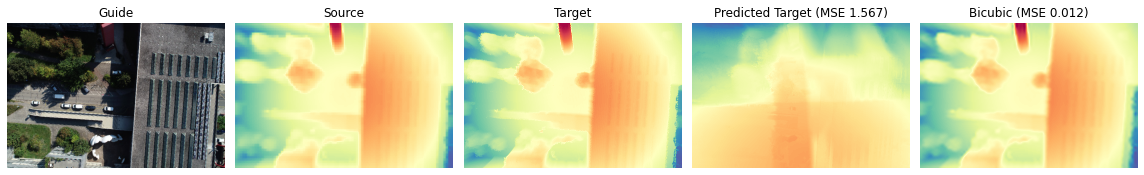

MSE: 1.567  ---  MAE: 1.031  ---  PBP: 0.463





In [26]:
bicubic_target_img = bicubic(source_img=source_img, scaling_factor=params['scaling'])

f, ax = plot_result(guide_img,source_img,predicted_target_img,bicubic_target_img,target_img)
plt.show()
# compute metrics and plot results
MSE = np.mean((predicted_target_img - target_img) ** 2)
MAE = np.mean(np.abs(predicted_target_img - target_img))
PBP = np.mean(np.abs(predicted_target_img - target_img) > params["delta_PBP"])

print("MSE: {:.3f}  ---  MAE: {:.3f}  ---  PBP: {:.3f}".format(MSE,MAE,PBP))
print("\n\n")
